In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as display

import PIL.Image
import functools
import time

from numpy.random import seed
seed(111)

mpl.rcParams['figure.figsize'] = (15,15)
mpl.rcParams['axes.grid'] = False

In [2]:
def to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
content_path = 'columbia.jpg'
style_path = 'van_Gogh.jpg'

In [4]:
def load_img(path):

  img = tf.io.read_file(path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  l = max(shape)
  scale = 512 / l

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def show_image(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

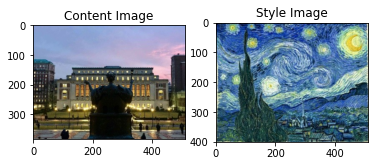

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
show_image(content_image, 'Content Image')

plt.subplot(1, 2, 2)
show_image(style_image, 'Style Image')

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
# the layers to extract the content
content_layers = ['block4_conv2'] 

# the layers to extract the style
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
def vgg_layers(layers):
  # load the pre-trained vgg 
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  output = [vgg.get_layer(name).output for name in layers]

  model = tf.keras.Model([vgg.input], output)
  return model

In [11]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [12]:
def gram_matrix(x):
  shape = tf.shape(x)
  out1 = tf.linalg.einsum('bijc,bijd->bcd', x, x)
  z = tf.cast(shape[1]*shape[2], tf.float32)
  return out1/z

In [13]:
class NeuralTransfer(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(NeuralTransfer, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False
    self.content_layers = content_layers
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)

  def call(self, img):
    "Expects float input in [0,1]"
    img = img*255.0
    img_pre = tf.keras.applications.vgg19.preprocess_input(img)
    img1 = self.vgg(img_pre)

    style = img1[:self.num_style_layers]
    style = [gram_matrix(s) for s in style]

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style)}

    content = img1[self.num_style_layers:]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content)}


    return {'style':style_dict,'content':content_dict}

In [14]:
extractor = NeuralTransfer(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

In [15]:
content_y = extractor(content_image)['content']
style_y = extractor(style_image)['style']

In [16]:
image = tf.Variable(content_image)

In [17]:
def image_clip(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

In [19]:
style_weight=1
content_weight=1e-3

In [20]:
def compute_loss(x):
    style = x['style']
    style_loss = tf.add_n([tf.reduce_mean((style[i]-style_y[i])**2) 
                           for i in style.keys()])
    style_loss *= style_weight/num_style_layers
    
    content = x['content']
    content_loss = tf.add_n([tf.reduce_mean((content[i]-content_y[i])**2) 
                             for i in content.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

In [21]:
def train_iter(image):
  with tf.GradientTape() as tape:
    x = extractor(image)
    loss = compute_loss(x)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(image_clip(image))

Try different iteration times

In [22]:
import time
import os
start = time.time()


step = 0
for i in range(15000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step in [10, 50, 100, 500, 1000, 5000, 10000,12000,14000,15000]:
    save_path = os.path.join("img_%s.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))
    end = time.time()
    print("current time: {:.1f}".format(end-start))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Output hidden; open in https://colab.research.google.com to view.

## try different random seed

In [27]:
random_seed = 111
tf.random.set_seed(random_seed)

In [28]:
opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

In [29]:
def train_iter(image):
  with tf.GradientTape() as tape:
    x = extractor(image)
    loss = compute_loss(x)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(image_clip(image))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

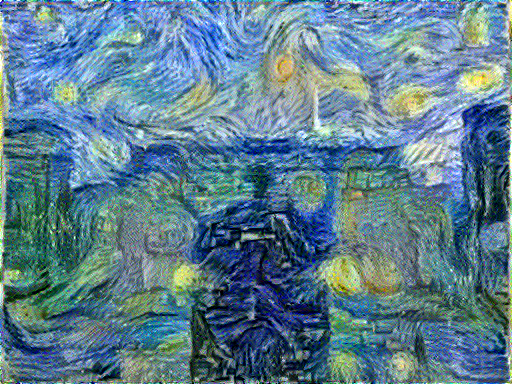

'img_1000_111.png'

train step: 1000
Total time: 127.0


In [30]:
step = 0
image = tf.Variable(content_image)
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("img_%s_111.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## seed


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

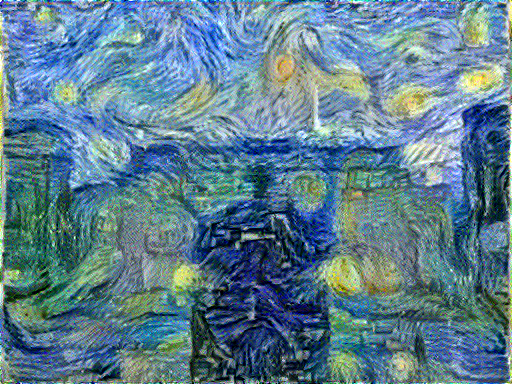

'img_1000_222.png'

train step: 1000
Total time: 126.3


In [31]:
tf.random.set_seed(222)

opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

def train_iter(image):
  with tf.GradientTape() as tape:
    x = extractor(image)
    loss = compute_loss(x)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(image_clip(image))
  
image = tf.Variable(content_image)
step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("img_%s_222.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

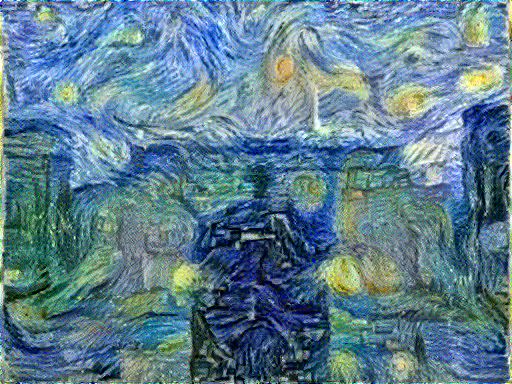

'img_1000_333.png'

train step: 1000
Total time: 127.1


In [32]:
tf.random.set_seed(333)

opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)


def train_iter(image):
  with tf.GradientTape() as tape:
    x = extractor(image)
    loss = compute_loss(x)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(image_clip(image))

image = tf.Variable(content_image)

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("img_%s_333.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

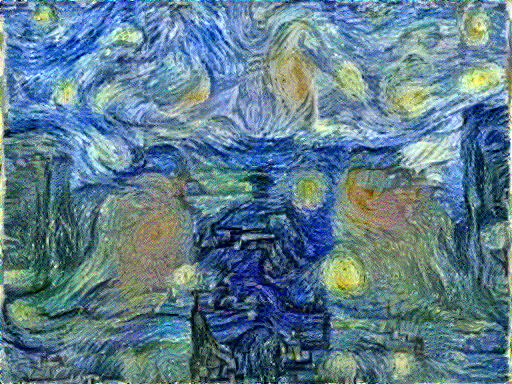

'img_1000_999.png'

train step: 1000
Total time: 126.3


In [33]:
tf.random.set_seed(999)

opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

def train_iter(image):
  with tf.GradientTape() as tape:
    x = extractor(image)
    loss = compute_loss(x)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(image_clip(image))

step = 0
start = time.time()
for i in range(1000):
  step += 1
  train_iter(image)
  print(".", end='')
  if step ==1000:
    save_path = os.path.join("img_%s_999.png"%(step))
    display.display(to_image(image),save_path)
    to_image(image).save(save_path)
    print("train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))